Housekeeping...

In [35]:
# Classic libraries
# from __future__ import division, print_function
import numpy as np
import sympy as sym
import pandas as pd
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sn # library for pretty plots. See https://stanford.edu/~mwaskom/software/seaborn/ 
sn.set_style('whitegrid')
cp = sn.xkcd_rgb["pinkish"]
cb = "#3498db"
cr = "#1fa774"
# Specialist functions
from scipy.optimize import minimize, root, fsolve
from scipy.optimize import leastsq, least_squares
from scipy.interpolate import interp1d
from scipy.special import erf
# Core functions - solve the problem and plot the results
import capital_new as capital
# Other extensions
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading data from Adamopoulos and Restuccia (2014)

In [36]:
CalUS = np.loadtxt('model_data.csv', delimiter=',').T
CalP = np.loadtxt('model_data_p.csv', delimiter=',').T
y_grid, y_prob, farm_grid, k_grid, output_m = CalUS
y_grid_p, y_prob_p, farm_grid_p, k_grid_p, output_m_p = CalP

# Replicating Adamopoulos and Restuccia (2014) and some more using Eeckhout and Kircher (2018)

This notebook shows how introducing heterogeneity in the quality of land changes the results or Adamopoulos and Restuccia (2014) (AR thereafter). This is based on the model of Assorative Martching with large firms of Eeckhout and Kircher (2018) (EK thereafter).

## Index

1. [Introduction](#sec1)
2. [Calculating $k^*$](#sec2)
3. [Solving original model](#sec3)
4. [Uneven spread of $x$](#sec4) \\ 4.1 [Generating the distributions](#sec41) \\
  4.2 [Solving the model](#sec42) \\
  4.3 [Results](#sec43) 
  
5. [The PAM condition](#sec5)



## 1. Introduction

The original AR paper's production function is:

$$ p_aA\kappa(\eta(k)^{\rho} + (1 -\eta)(yl))^{\rho})^{\frac{\gamma}{\rho}} $$

Where:
- $y \to$ farmer skill
- $l \to$ farm size
- $k \to$ capital

The rest are parameters that are calibrated to match the farm size distribution of the US and the capital to land ratio.

EK introduce two more variables:
- $x \to$ land quality
- $r \to$ farmer *supervising intentisty*, normalized to 1.

Adding heterogenity in land quality ($x$) to the AR model requires a different solution method. 

The optimal choice of $k$ can be calculated as a function of the other variables so that the problem can be solved as an initial value problem (IVP) in the standard EK way. That is, finding $k^*$ such that 
$$k^*(x,y,l,r) = \mathrm{argmax}_{k}F(x,y,l,r,k)-rRk$$

There is a number of ways of introducing these $x$ and $r$, of which 4 were considered. Below is the list of all tehm, with their accompaning first order condiction (FOC) for solving for $k^*(x,y,l,r)$.

| # | name | function | FOC    |
|---| ---- |:--------:|:--------:|
| 0 | $\color{red}{x}$ with $l/r$ | $ rp_aA\kappa(\eta(k)^{1/4} + (1 -\eta)(y(l/r)^{\color{red}{x}})^{1/4})^{2} - rRk$ | $ K^{3} + -\frac{Ap_a\kappa\eta^{2}}{2R} K + \frac{Ap_a\kappa\eta(1 -\eta)(y(\frac{l}{r})^{x})^{1/4}}{2R}   = 0$ |
| 1 | $\color{red}{x}$ with $A$ | $ rp_a\color{red}{x}A\kappa [\eta (k)^{1/4} + (1-\eta)(y(l/r))^{1/4} ]^2 - rRk $ | $K^3 - \frac{xAp_a\kappa\eta^2}{2R}K - \frac{xAp_a\kappa\eta(1-\eta)(y\frac{l}{r})^{1/4}}{2R}= 0 $ |
| 2 | $\color{red}{x}$ with $k$ | $ rp_aA\kappa [\eta (k\color{red}{x})^{1/4} + (1-\eta)(y(l/r))^{1/4} ]^2 - rRk $ | $K^3 - \frac{Ap_a\kappa\eta^2 x^{1/2}}{2R}K - \frac{Ap_a\kappa\eta(1-\eta)(xy\frac{l}{r})^{1/4}}{2R}= 0 $ |
| 3 | $\color{red}{x}$ with $k$ (out of the bracket) | $ rp_aA\kappa [\eta \color{red}{x} k^{1/4} + (1-\eta)(y(l/r))^{1/4} ]^2 - rRk $ | $K^3 - \frac{Ap_a\kappa\eta^2 x^2}{2R}K - \frac{Ap_a\kappa\eta(1-\eta)(y\frac{l}{r})^{1/4} x}{2R}= 0 $
| 4 | $k^{\color{red}{x}}$ | $ rp_aA\kappa(\eta(k)^{\color{red}{x}/4} + (1 -\eta)(y(l/r))^{1/4})^{2} - rRk$   | None |
*Note: $K = k^{1/4}$*

For the case of $k^{\color{red}{x}}$, there is no closed-form solution and $k^*$ has to be solved numerically. Solving the model with this especification renders the shooting solver unstable, therefore it is not used. Nevertheless, `new_capital.py` includes a function to approximate this point by point.

Inside the code the problem is reformulated, using an equivalent production function

$$lp_aA\kappa \left( \eta(k)^{\rho} + (1 -\eta)(x(r/l)^{y})^{\rho} \right) ^{\frac{\gamma}{\rho}} - lRk$$.

The original formulation the shooting solver is unable to match the lowest values of $y$ (0.000003). This transformation does not alter the results, but requires some care when dealing with the results: farm size ($\theta = \frac{l}{r}$) coming from the solver would be the inverse of model $\theta$, and in the code below you'll find `xs` refering to farmer skill ($y$ in the model). Several times in this notebook there the change in variables will be made explicit.

For the rest of the functional forms, $k^*$ is found by solving a cubic root problem. This is done in section 2. `new_capital.py` approximates the solution with cubic or quadratic "tensor" polynomials - that is, polynomials with cross-products. This solves a multiple root problem and gives an easily differentiable expression. This approximation allows to use the shooting solver wihtout major complications - at the price of some numerical error.

Once $k^*$ has been found, we proceed to solve for the baseline case where $x=1$ (section 3) and then increase the spread up to $x\in[0.75,1.25]$ (section 4). In this application we use a shooting algorithm with logaritmic steps.

Worker skill $x$ is set to follow a lognormal distribution with mean 1. This distribution makes the results move *closest* to the data - that is, small farms increasing size, but not much. Section 4 provides the results for different distributions and spreads.

Finally, section 5 provides the symolic derivatives to the production function and checks numerically that PAM holds for any combination of $x,y,l,r$ and $k$ - given the parameters of AR. **Upadate**: The PAM condition has been corrected and it's checked for at each step numerically and graphically. The new condition is described in the Corrigendum to EK.

<a id='sec2'></a>
## 2 Calculating $k^*$

First step is to declare the parameters of the parameters of the rich and poor countries. Then these are fed to the `get_k` function - this calculates the optimal $k^*$ function for a given spread of x. The function also prints the sum or squared errors of the approximation. 

The default option for the functional form is function (0) above: $ p_aA\kappa(\eta(k)^{\rho} + (1 -\eta)(y(l/r)^{x})^{\rho})^{\frac{\gamma}{\rho}} - Rk$. 

Rich country (US calibration):

In [37]:
pam_dic_R = {'A': 1.0, 'eta': 0.890204456766942, 'kappa': 0.3159, 'R':0.13099, 'rho': 0.25, 'gamma': 0.5}
pam_dic_P = {'A': 0.3987, 'eta': 0.890204456766942, 'kappa': 0.5209, 'R':0.3958, 'rho': 0.25, 'gamma': 0.5 }

k_star_R = capital.get_k(pam_dic_R, x_range=[0.9,1.1],print_residuals=True)
k_star_P = capital.get_k(pam_dic_P, x_range=[0.9,1.1],print_residuals=True)

0.0006049062442879255
0.00322205421125489


This cell defines the symbolical expression from PAM as defined in the Corrigendum:

In [38]:
x, y, k = sym.var('x, y, k')
R, l, r, A, kappa, p_a, rho, gamma, eta = sym.var('R, l, r, A, kappa, p_a, rho, gamma, eta')

sym.init_printing()

F0 = r*A*kappa*(eta*k**rho + (1- eta)*(((l/r)**x)*y)**rho)**(gamma/rho)
F1 = r*A*kappa*x*(eta*k**rho + (1- eta)*((l/r)*y)**rho)**(gamma/rho)
F2 = r*A*kappa*(eta*(x*k)**rho + (1- eta)*((l/r)*y)**rho)**(gamma/rho)
F3 = r*A*kappa*(x*eta*k**rho + (1- eta)*((l/r)*y)**rho)**(gamma/rho)
F4 = r*A*kappa*(eta*k**(rho*x) + (1- eta)*((l/r)*y)**rho)**(gamma/rho)

lhs = F0.diff(x,y)*F0.diff(l,r)*F0.diff(k,k) - F0.diff(x,y)*F0.diff(l,k)*F0.diff(r,k) - F0.diff(x,k)*F0.diff(y,k)*F0.diff(l,r)
rhs = F0.diff(x,r)*F0.diff(y,l)*F0.diff(k,k) - F0.diff(x,r)*F0.diff(y,k)*F0.diff(l,k) - F0.diff(x,k)*F0.diff(y,l)*F0.diff(r,k)

PAM_R = sym.lambdify((x,y,l,r,k),sym.simplify(lhs-rhs).subs(pam_dic_R))
PAM_P = sym.lambdify((x,y,l,r,k),sym.simplify(lhs-rhs).subs(pam_dic_P))

<a id='sec3'></a>
## 3 Solving original model ($x=1$)

The following solves for the parameters of the rich country with no spread of $x$ - or $x \in (0.99999,1.00001)$.

In [51]:
sol_R1 = capital.solve("R", k_star_R, ftype=0,assort='positive',                       
                       verbose=False,guess_overide=0.8)

Success! All workers and firms are matched


The warning about the PAM condition refers to the fact that for some points the PAM condition as defined in EK are not fulfilled:

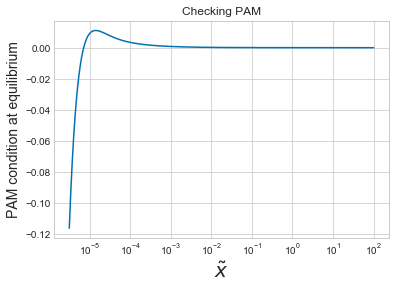

In [49]:
ders = capital.derivatives(sol_R1, "R")
capital.plot_PAM(ders, sol_R1['xs'])

However this is steeming from both (i) the approximation error of $k^*$ and (ii) the inversion of the problem.

If we check for the true PAM condition as defined from the Corrigendum the solution does satisfy this:

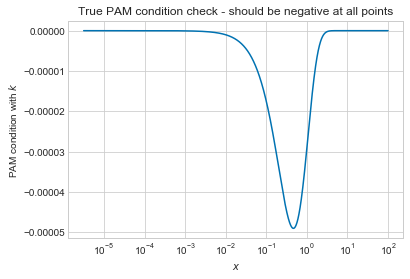

In [57]:
plt.plot(sol_R1['xs'],PAM_R(sol_R1['xs'],sol_R1['ys'],sol_R1['thetas'],1.0,sol_R1['ks']))
plt.title('True PAM condition check - should be negative at all points')
plt.xscale("log")
plt.ylabel('PAM condition with $k$')
plt.xlabel('$x$')
plt.show()

In [53]:
print("Points for which the PAM condition doesn't hold:", 
      np.sum(PAM_R(sol_R1['ys'],sol_R1['xs'],sol_R1['thetas'],1.0,sol_R1['ks'])>=0))

Points for which the PAM condition doesn't hold: 0


Solution plot:

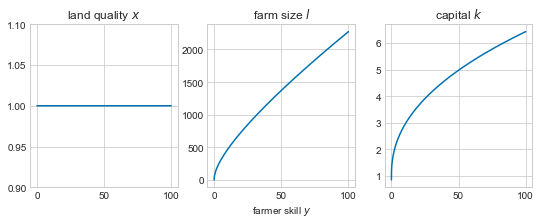

In [54]:
plt.figure(figsize=(9,3))
plt.subplot(131)
plt.title('land quality $x$')
plt.plot(sol_R1['xs'],sol_R1['ys'])
plt.ylim(0.9,1.1)
plt.subplot(132)
plt.title('farm size $l$')
plt.plot(sol_R1['xs'],1/sol_R1['thetas'])
plt.xlabel('farmer skill $y$')
plt.subplot(133)
plt.title('capital $k$')
plt.plot(sol_R1['xs'],sol_R1['ks'])
plt.show()

### Poor country parameters

Same procedure: solving first, checking PAM and plotting results.

In [55]:
sol_P1 = capital.solve("P", k_star_P, ftype=0,assort='positive',
                       verbose=False,guess_overide=2.0) #guess_overide=2000.0, scaling_x=0.90607341901223637,

Success! All workers and firms are matched


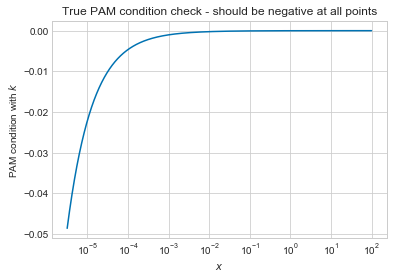

In [56]:
plt.plot(sol_P1['xs'],PAM_P(sol_P1['ys'],sol_P1['xs'],1/sol_P1['thetas'],1.0,sol_P1['ks']))
plt.title('True PAM condition check - should be negative at all points')
plt.xscale("log")
plt.ylabel('PAM condition with $k$')
plt.xlabel('$x$')
plt.show()

In [58]:
print("Points for which the PAM condition doesn't hold:", 
      np.sum(PAM_P(sol_P1['ys'],sol_P1['xs'],1/sol_P1['thetas'],1.0,sol_P1['ks'])>0))

Points for which the PAM condition doesn't hold: 0


Histogram comparing with the results with AR (Figure 7 in the appendix of AR):

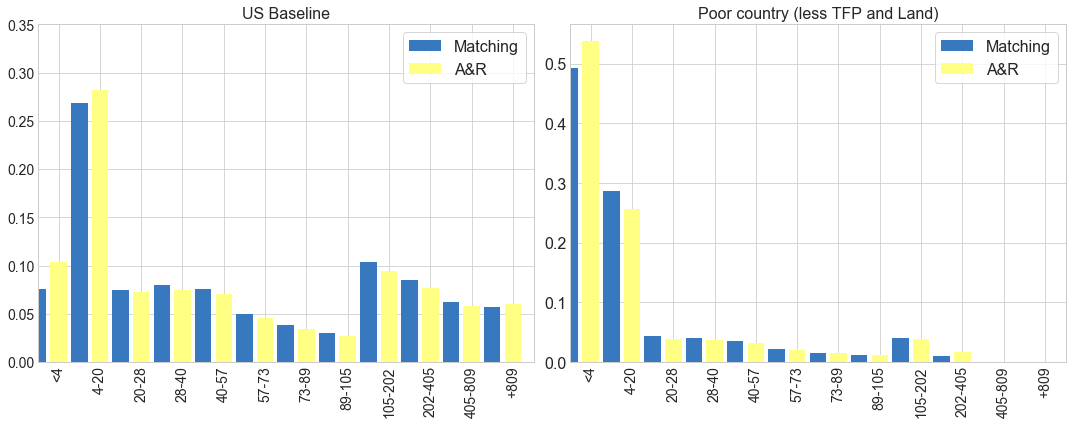

In [39]:
capital.plot_histogram(sol_R1,sol_P1,CalUS,CalP)

<a id='sec4'></a>
## 4. Uneven spread of x

Here the spread of land quality $x$ increases. Although in the end only the lognormal distribution is used, illustrations with other distributions are shown as well to illustrate graphically how the distribution of $x$ could change the results.

<a id='sec41'></a>
### 4.1 Generating the distributions

Lognormal distribution:

In [8]:
_modules = [{'ImmutableMatrix': np.array, 'erf': erf, 'sqrt': np.sqrt}, 'numpy']

x, loc2, mu2, sigma2 = sym.var('x, loc2, mu2, sigma2')
productivity_cdf = (0.5 + 0.5 * sym.erf((sym.log(x - loc2) - mu2) / sym.sqrt(2 * sigma2**2)))

productivity_params_lognorm = {'loc2': 0.0, 'mu2': 0.00, 'sigma2': 0.20}

pdf_lognorm = productivity_cdf.diff(x).subs(productivity_params_lognorm)
pdf_exe_lognorm = sym.lambdify(x, pdf_lognorm, 'numpy')
cdf_exe_lognorm = sym.lambdify(x, productivity_cdf.subs(productivity_params_lognorm), _modules)

Bimodal

In [9]:
sig1, sig2, x, mu1, mu2= sym.var("sig1, sig2, x, mu1, mu2")
c1 = 0.5 * (1 + sym.erf((x-mu1)/ sym.sqrt(2 * sig1**2)))
c2 = 0.5 * (1 + sym.erf((x-mu2)/ sym.sqrt(2 * sig2**2)))
cdf = c1*0.5+c2*0.5

params_bimod = {'mu1': 0.93333, 'mu2': 1.06667, 'sig1': 0.033,'sig2': 0.033}

pdf_bimod = cdf.diff(x).subs(params_bimod)
cdf_bimod = cdf.subs(params_bimod)

pdf_exe_bimod = sym.lambdify(x, pdf_bimod,  _modules)
cdf_exe_bimod = sym.lambdify(x, cdf_bimod,  _modules)

Normal

In [10]:
params_norm = {'mu1': 1.0, 'sig1': 0.06666 }

pdf_norm = c1.diff(x).subs(params_norm)
cdf_norm = c1.subs(params_norm)

pdf_exe_norm = sym.lambdify(x, pdf_norm,  _modules)
cdf_exe_norm = sym.lambdify(x, cdf_norm,  _modules)

Normalising constants - so total ammount of land integrates to 1.

In [11]:
norm_bimod = 1/(cdf_exe_bimod(1.1)-cdf_exe_bimod(0.9))
norm_norm = 1/(cdf_exe_norm(1.1)-cdf_exe_norm(0.9))
norm_lognorm = 1/(cdf_exe_lognorm(1.1)-cdf_exe_lognorm(0.9))

c_bimod = cdf_exe_bimod(1.1)*norm_bimod-1
c_norm= cdf_exe_norm(1.1)*norm_norm-1
c_lognorm= cdf_exe_lognorm(1.1)*norm_lognorm-1

Normalising constants for different spreads, lognormal distribution

In [12]:
norm_lognorm_05 = 1/(cdf_exe_lognorm(1.05)-cdf_exe_lognorm(0.95))
c_lognorm_05 = cdf_exe_lognorm(1.05)*norm_lognorm_05-1

norm_lognorm_10 = 1/(cdf_exe_lognorm(1.1)-cdf_exe_lognorm(0.9))
c_lognorm_10 = cdf_exe_lognorm(1.1)*norm_lognorm_10-1

norm_lognorm_15 = 1/(cdf_exe_lognorm(1.15)-cdf_exe_lognorm(0.85))
c_lognorm_15 = cdf_exe_lognorm(1.15)*norm_lognorm_15-1

norm_lognorm_20 = 1/(cdf_exe_lognorm(1.2)-cdf_exe_lognorm(0.8))
c_lognorm_20 = cdf_exe_lognorm(1.2)*norm_lognorm_20-1

norm_lognorm_25 = 1/(cdf_exe_lognorm(1.25)-cdf_exe_lognorm(0.75))
c_lognorm_25 = cdf_exe_lognorm(1.25)*norm_lognorm_25-1

norm_lognorm_30 = 1/(cdf_exe_lognorm(1.3)-cdf_exe_lognorm(0.7))
c_lognorm_30 = cdf_exe_lognorm(1.3)*norm_lognorm_30-1

Plots of the different distributions

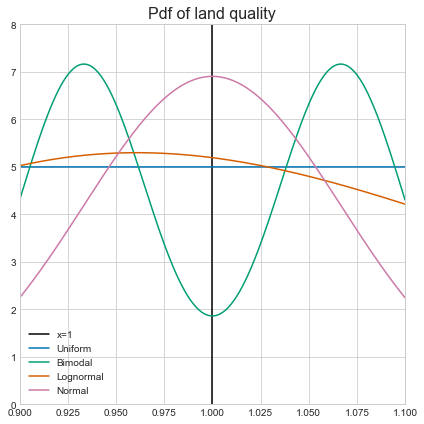

In [23]:
xss = np.linspace(0.9,1.1,6000)
plt.figure(figsize=(6,6))
sn.set_palette('colorblind', 5)
plt.axvline(1.0,label="x=1", c= 'black')
plt.plot(xss,5*np.ones(len(xss)), label="Uniform")
plt.plot(xss,pdf_exe_bimod(xss)*norm_bimod, label='Bimodal')
plt.plot(xss,pdf_exe_lognorm(xss)*norm_lognorm, label="Lognormal")
plt.xlim(0.9,1.1)
plt.ylim(0,8)
plt.title("Pdf of land quality", fontsize=16)
plt.plot(xss,pdf_exe_norm(xss)*norm_norm, label='Normal')


plt.tight_layout()
plt.legend(loc='best')
plt.show()

<a id='sec42'></a>
### 4.2 Solving the model

The distribution that used in the paper is the lognormal. This distribution delivers the results closer to the data provided in AR.

In [24]:
# Execute this cell to store results
sol_log = {}
sol_logP = {}

Calculating $k^*(x,y,l,r)$ for different $x$ spreads:

In [26]:
k_star_R25 = capital.get_k(pam_dic_R, x_range=[0.75,1.25],print_residuals=True)
k_star_P25 = capital.get_k(pam_dic_P, x_range=[0.75,1.25],print_residuals=True)

k_star_R30 = capital.get_k(pam_dic_R, x_range=[0.7,1.3],print_residuals=True)
k_star_P30 = capital.get_k(pam_dic_P, x_range=[0.7,1.3],print_residuals=True)

0.0007566085962773021
0.004719416672145595
0.0008611003591574059
0.00560531009701687


Lognormal

In [27]:
sol_log[2605] = capital.solve("R", k_star_R, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.95,1.05],scaling_x=norm_lognorm_05, normconst=c_lognorm_05)
sol_logP[2605]= capital.solve("P", k_star_P, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.95,1.05],scaling_x=norm_lognorm_05, normconst=c_lognorm_05)

Success! All workers and firms are matched
Approximated solution failed to satisfy required assortativity condition.
Success! All workers and firms are matched
Approximated solution failed to satisfy required assortativity condition.


In [28]:
sol_log[2610] = capital.solve("R", k_star_R, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.9,1.1],scaling_x=norm_lognorm_10, normconst=c_lognorm_10)
sol_logP[2610]= capital.solve("P", k_star_P, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.9,1.1],scaling_x=norm_lognorm_10, normconst=c_lognorm_10)

Success! All workers and firms are matched
Success! All workers and firms are matched
Approximated solution failed to satisfy required assortativity condition.


In [29]:
sol_log[2615] = capital.solve("R", k_star_R25, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.85,1.15],scaling_x=norm_lognorm_15, normconst=c_lognorm_15,guess_overide=1/250)
sol_logP[2615]= capital.solve("P", k_star_P25, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.85,1.15],scaling_x=norm_lognorm_15, normconst=c_lognorm_15,guess_overide=1/250)

Success! All workers and firms are matched
Success! All workers and firms are matched
Approximated solution failed to satisfy required assortativity condition.


In [30]:
sol_log[2620] = capital.solve("R", k_star_R25, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.8,1.20],scaling_x=norm_lognorm_20, normconst=c_lognorm_20,guess_overide=1/250)
sol_logP[2620]= capital.solve("P", k_star_P25, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.8,1.20],scaling_x=norm_lognorm_20, normconst=c_lognorm_20,guess_overide=1/250)

Success! All workers and firms are matched
Approximated solution failed to satisfy required assortativity condition.
Success! All workers and firms are matched
Approximated solution failed to satisfy required assortativity condition.


In [31]:
sol_log[2625] = capital.solve("R", k_star_R25, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.75,1.25],scaling_x=norm_lognorm_25, normconst=c_lognorm_25,guess_overide=1/250)
sol_logP[2625]= capital.solve("P", k_star_P25, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.75,1.25],scaling_x=norm_lognorm_25, normconst=c_lognorm_25,guess_overide=1/250)

Success! All workers and firms are matched
Approximated solution failed to satisfy required assortativity condition.
Success! All workers and firms are matched
Approximated solution failed to satisfy required assortativity condition.


In [32]:
sol_log[2630] = capital.solve("R", k_star_R30, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.7,1.3],scaling_x=norm_lognorm_30, normconst=c_lognorm_30,guess_overide=1/250)
sol_logP[2630]= capital.solve("P", k_star_P30, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.7,1.3],scaling_x=norm_lognorm_30, normconst=c_lognorm_30,guess_overide=1/250)

Success! All workers and firms are matched
Approximated solution failed to satisfy required assortativity condition.
Success! All workers and firms are matched
Approximated solution failed to satisfy required assortativity condition.


In [60]:
# solsR = (sol_R1,sol_log[2605],sol_log[2610],sol_log[2615],sol_log[2620],sol_log[2625],sol_log[2630])
# solsP = (sol_P1,sol_logP[2605],sol_logP[2610],sol_logP[2615],sol_logP[2620],sol_logP[2625],sol_logP[2630])
# labs = ('$x=0$','$x\in[0.95,1.05]$ ','$x\in[0.90,1.10]$','$x\in[0.85,1.15]$','$x\in[0.80,1.20]$','$x\in[0.75,1.25]$','$x\in[0.70,1.30]$')

solsR = (sol_R1,sol_log[2610],sol_log[2620],sol_log[2630])
solsP = (sol_P1,sol_logP[2610],sol_logP[2620],sol_logP[2630])
labs = ('$x=1$','$x\in[0.90,1.10]$','$x\in[0.80,1.20]$','$x\in[0.70,1.30]$')

### Checking for PAM

As in the case of $x=1$ (all land quality is the same), we need to check ex-post for the PAM condition with capital. This needs to be negative at all points.

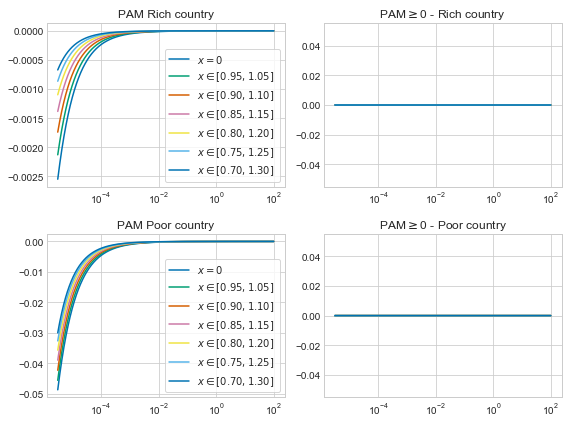

In [59]:
plt.figure(figsize=(8,6))
plt.subplot(221)
plt.title('PAM Rich country')
for i,sol in enumerate(solsR):
    plt.plot(sol['xs'],PAM_R(sol['ys'],sol['xs'],1/sol['thetas'],1.0,sol['ks']), label=labs[i])
# plt.plot(sol_log[2625]['xs'],PAM_R(sol_log[2625]['ys'],sol_log[2625]['xs'],1/sol_log[2625]['thetas'],1.0,sol_log[2625]['ks']))
# plt.ylim(-0.2,0.2)
plt.legend(frameon=True)
plt.xscale("log")

plt.subplot(222)
plt.title('PAM$\geq$0 - Rich country')
for i,sol in enumerate(solsR):
    plt.plot(sol['xs'],PAM_R(sol['ys'],sol['xs'],1/sol['thetas'],1.0,sol['ks'])>=0, label=labs[i])
# plt.plot(sol_log[2625]['xs'],PAM_R(sol_log[2625]['ys'],sol_log[2625]['xs'],1/sol_log[2625]['thetas'],1.0,sol_log[2625]['ks'])>=0)
# plt.ylim(-0.2,0.2)
plt.xscale("log")

plt.subplot(223)
plt.title('PAM Poor country')
for i,sol in enumerate(solsP):
    plt.plot(sol['xs'],PAM_P(sol['ys'],sol['xs'],1/sol['thetas'],1.0,sol['ks']), label=labs[i])
# plt.ylim(-0.2,0.2)
plt.legend(frameon=True)
plt.xscale("log")

plt.subplot(224)
plt.title('PAM$\geq$0 - Poor country')
for i,sol in enumerate(solsP):
    plt.plot(sol['xs'],PAM_P(sol['ys'],sol['xs'],1/sol['thetas'],1.0,sol['ks'])>0, label=labs[i])

# plt.plot(sol_logP[2625]['xs'],PAM_P(sol_logP[2625]['ys'],sol_logP[2625]['xs'],1/sol_logP[2625]['thetas'],1.0,sol_logP[2625]['ks'])>=0)
# plt.ylim(-0.2,0.2)
plt.xscale("log")

plt.tight_layout()
plt.show()

In [50]:
# Repackaging cell - uncomment if needed
# solsR = [sol_R1,] + list(sol_R10.values())
# solsP = [sol_P1] + list(sol_P10.values())
# labs = ('$x=1$','$x\in[0.975,1.025]$ ','$x\in[0.95,1.05]$ ','$x\in[0.925,1.075]$','$x\in[0.9,1.1]$')

In [36]:
# Saving results cell - uncomment if needed
# for i,sol in enumerate(solsR):
#     data = np.vstack((sol['xs'],sol['ys'],1/sol['thetas'],sol['ks'])).T
#     np.savetxt('solR_'+labs[i]+'.csv', data, delimiter=',',header='xs, ys, ls, ks')
    
# for i,sol in enumerate(solsP):
#     data = np.vstack((sol['xs'],sol['ys'],1/sol['thetas'],sol['ks'])).T
#     np.savetxt('solP_'+labs[i]+'.csv', data, delimiter=',',header='xs, ys, ls, ks')

In [82]:
# Loading results cell - uncomment if needed
# labs = ('$x=1$','$x\in[0.90,1.10]$','$x\in[0.80,1.20]$','$x\in[0.70,1.30]$')
# solsP = []
# for i,sol in enumerate(labs):
#     buffsol = pd.read_csv('solP_'+labs[i]+'.csv', header=0,names=['xs', 'ys', 'thetas', 'ks'])
#     buffsol['thetas'] = 1/buffsol['thetas']
#     solsP.append(buffsol)
# solsR = []
# for i,sol in enumerate(labs):
#     buffsol = pd.read_csv('solR_'+labs[i]+'.csv', header=0,names=['xs', 'ys', 'thetas', 'ks'])
#     buffsol['thetas'] = 1/buffsol['thetas']
#     solsR.append(buffsol)
    

<a id='sec43'></a>
## 4.3 Results


**Changes in farm size for widening spreads of $x$ **

In levels:

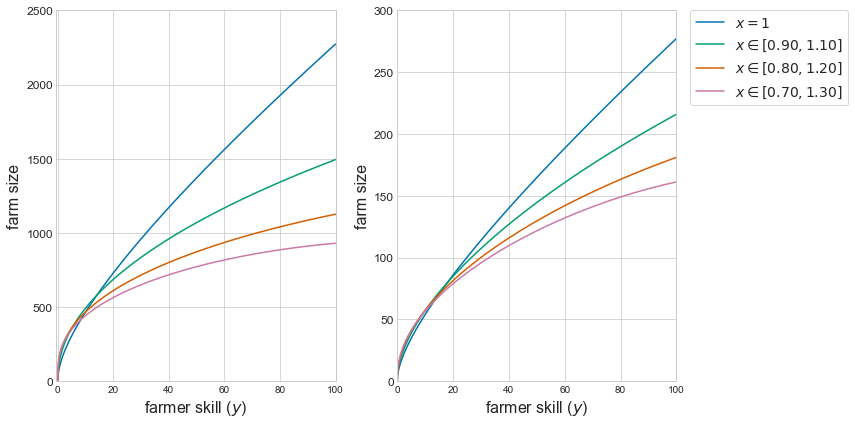

In [84]:
capital.plot_comparative_land_choice(solsR,labs,solsP,labs, color=True, logs=False)

Focusing in the case of the poor country (Figure 1 in the corrigendum):

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


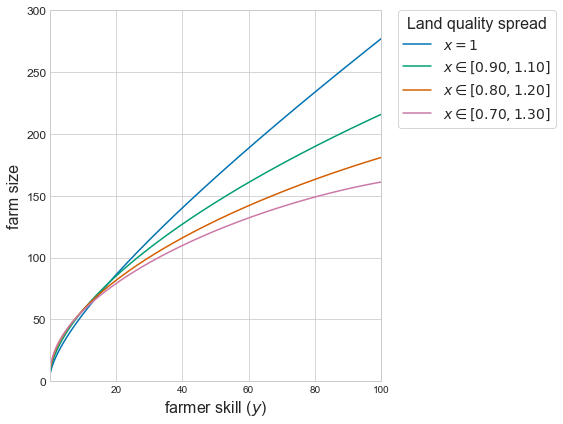

In [110]:
capital.plot_land_choice(solsP,labs, color=True, yscale=300,logs=False,save_in='land_choice_corrigendum.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


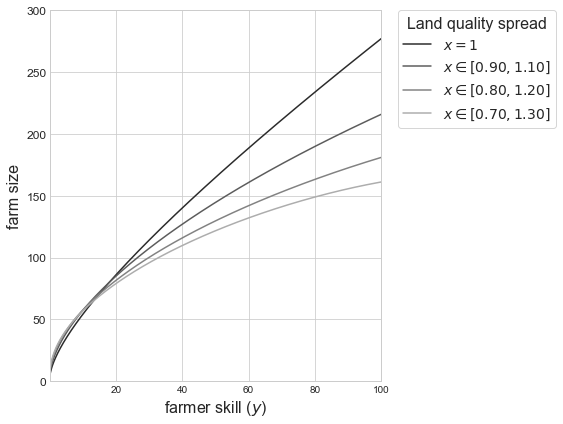

In [113]:
capital.plot_land_choice(solsP,labs, color=False, yscale=300,logs=False,save_in='land_choice_corrigendum_bw.eps')

In logs:

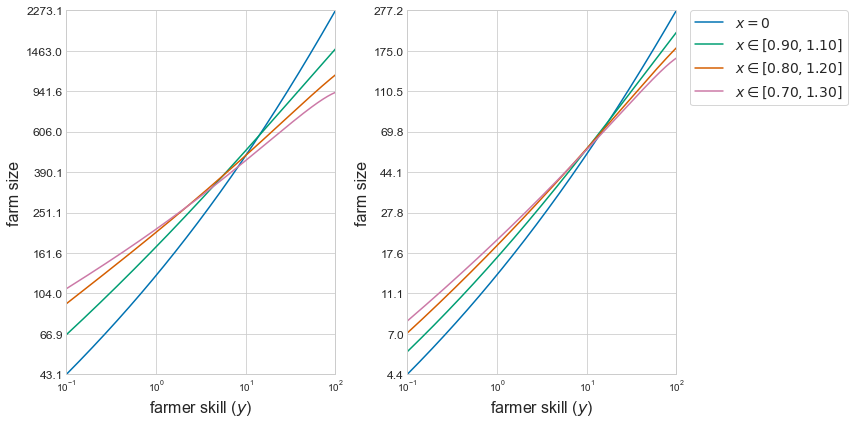

In [74]:
capital.plot_comparative_land_choice(solsR,labs,solsP,labs, color=True, logs=True)

### Other Figures

** $k/l$ ratios **

These show the $k/l$ ratio normalized by the largest farm. That is, is $k/l=100$ for the largest farm, the $k/l$ ratio of the rest is divided by 100.

Rinch country on the left, poor country on the right.

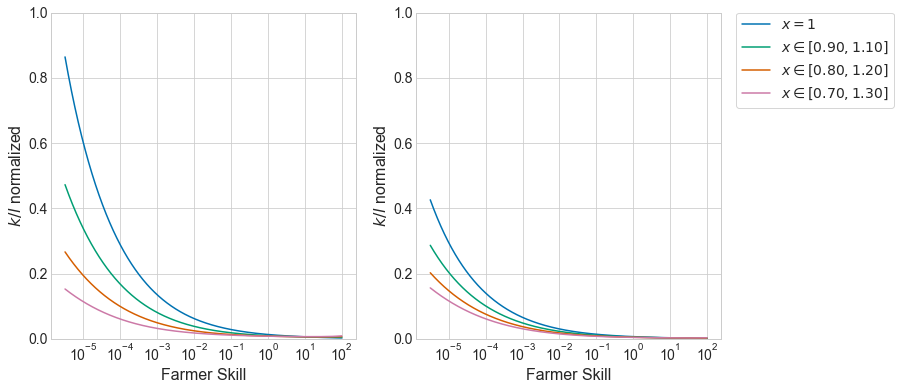

In [91]:
capital.plot_kl_ratio(solsR,labs,solsP,labs,save_in=None,color=True)

** Distribution plots **

Rich country:

In [95]:
capital.plot_dischange(solsR[0],solsR[2],extras=[solsR[1],(0.9,1.1)],xrange=(0.8,1.2),
                            save_in=None,allplots=False,color=True, uc=cr)

KeyError: 'pdf_dis'

Poor country:

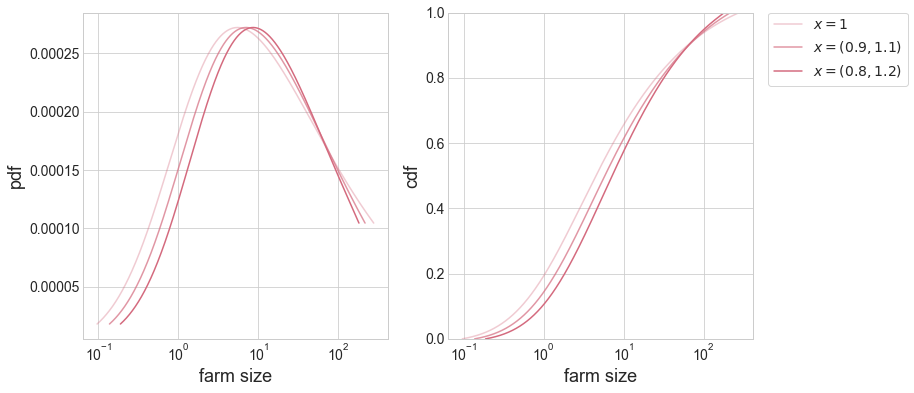

In [69]:
capital.plot_dischange(sol_P1,sol_logP[2620],extras=[sol_logP[2610],(0.9,1.1)],xrange=(0.8,1.2),
                            save_in=None, allplots=False,color=True,uc=cp)

<a id='sec5'></a>
## 5. PAM condition

Finally, the formal, numerical check of the PAM condition. If lhs-rhs > 0, then PAM holds.

First without substituiting parameters:

In [100]:
x, y, k = sym.var('x, y, k')
R, l, r, A, kappa, p_a, rho, gamma, eta = sym.var('R, l, r, A, kappa, p_a, rho, gamma, eta')
pam_dic_P['rho']=0.25
pam_dic_P['gamma']=0.5

pam_dic_R['rho']=0.25
pam_dic_R['gamma']=0.5

sym.init_printing()

F0 = r*A*kappa*(eta*k**rho + (1- eta)*(((l/r)**x)*y)**rho)**(gamma/rho)
F1 = r*A*kappa*x*(eta*k**rho + (1- eta)*((l/r)*y)**rho)**(gamma/rho)
F2 = r*A*kappa*(eta*(x*k)**rho + (1- eta)*((l/r)*y)**rho)**(gamma/rho)
F3 = r*A*kappa*(x*eta*k**rho + (1- eta)*((l/r)*y)**rho)**(gamma/rho)
F4 = r*A*kappa*(eta*k**(rho*x) + (1- eta)*((l/r)*y)**rho)**(gamma/rho)

Now substituting for the parameters of the rich country:

In [104]:
lhs = F0.diff(x,y)*F0.diff(l,r)*F0.diff(k,k) - F0.diff(x,y)*F0.diff(l,k)*F0.diff(r,k) - F0.diff(x,k)*F0.diff(y,k)*F0.diff(l,r)
rhs = F0.diff(x,r)*F0.diff(y,l)*F0.diff(k,k) - F0.diff(x,r)*F0.diff(y,k)*F0.diff(l,k) - F0.diff(x,k)*F0.diff(y,l)*F0.diff(r,k)
print(sym.simplify(lhs-rhs).subs(pam_dic_R))

0.00350791171645153*k**(-1.75)*r**2*x*(y*(l/r)**x)**0.5*(-0.00134143366352266*k**0.25 - 0.000496347002123088*(y*(l/r)**x)**0.25)*(0.890204456766942*k**0.25 + 0.109795543233058*(y*(l/r)**x)**0.25)**6.0/(l*y*(0.00471307000952237*k**0.25*(y*(l/r)**x)**0.75 + 0.0573192108348017*k**0.5*(y*(l/r)**x)**0.5 + 0.309823243220936*k**0.75*(y*(l/r)**x)**0.25 + 0.627999151431458*k**1.0 + 0.000145324503280975*(y*(l/r)**x)**1.0))


Now substituting for the parameters of the poor country:

In [102]:
print(sym.simplify(lhs-rhs).subs(pam_dic_P))

0.000996785143643158*k**(-1.75)*r**2*x*(y*(l/r)**x)**0.5*(-0.00134143366352266*k**0.25 - 0.000496347002123088*(y*(l/r)**x)**0.25)*(0.890204456766942*k**0.25 + 0.109795543233058*(y*(l/r)**x)**0.25)**6.0/(l*y*(0.00471307000952237*k**0.25*(y*(l/r)**x)**0.75 + 0.0573192108348017*k**0.5*(y*(l/r)**x)**0.5 + 0.309823243220936*k**0.75*(y*(l/r)**x)**0.25 + 0.627999151431458*k**1.0 + 0.000145324503280975*(y*(l/r)**x)**1.0))
